In [ ]:
%cd /content/
%rm -rf LLaMA-Factory
!git clone --depth 1 https://github.com/hiyouga/LLaMA-Factory.git
%cd LLaMA-Factory
%ls

!pip install -e .[torch,bitsandbytes]
!pip install -q numpy==2.0.2

/content
Cloning into 'LLaMA-Factory'...
remote: Enumerating objects: 353, done.
remote: Counting objects: 100% (353/353), done.
remote: Compressing objects: 100% (283/283), done.
remote: Total 353 (delta 95), reused 168 (delta 56), pack-reused 0 (from 0)
Receiving objects: 100% (353/353), 9.70 MiB | 16.34 MiB/s, done.
Resolving deltas: 100% (95/95), done.
/content/LLaMA-Factory
assets/       evaluation/  MANIFEST.in     requirements.txt  tests/
CITATION.cff  examples/    pyproject.toml  scripts/
data/         LICENSE      README.md       setup.py
docker/       Makefile     README_zh.md    src/
Obtaining file:///content/LLaMA-Factory
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
%cd /content/
!git clone https://huggingface.co/Qwen/Qwen2.5-1.5B-Instruct

/content
Cloning into 'Qwen2.5-1.5B-Instruct'...
remote: Enumerating objects: 31, done.
remote: Total 31 (delta 0), reused 0 (delta 0), pack-reused 31 (from 1)
Unpacking objects: 100% (31/31), 3.60 MiB | 6.59 MiB/s, done.


In [ ]:
import json
from pathlib import Path
from google.colab import drive
import random
import json
from tabulate import tabulate

drive.mount('/content/drive')
# /content/drive/MyDrive/Colab Notebooks/fineTune

Mounted at /content/drive


In [ ]:
def read_jsonl(file_path):
    data = []
    with open(file_path, "r", encoding="utf-8") as f:
        for line in f:
            data.append(json.loads(line))
    return data

def convert_to_alpaca(data, all_data, ref = False):

    for i in range(len(data)):
        otp = data[i]["output"]

        if ref == True:
            inp = "\t".join(data[i]["reference"]) + data[i]["input"] # special case only for Triplet because "ref" exist in the "input" in Triplet-QA
        inp = data[i]["input"]

        item = {
        "instruction": inp,
        "input": "",
        "output": otp
    }
        all_data.append(item)

    return all_data

# load all data
%cd /content/drive/MyDrive/Colab Notebooks/fineTune/DISC_LAW
data_p = read_jsonl("DISC-Law-SFT-Pair.jsonl")
data_pqa = read_jsonl("DISC-Law-SFT-Pair-QA-released.jsonl")
data_t = read_jsonl("DISC-Law-SFT-Triplet-released.jsonl")
data_tqa = read_jsonl("DISC-Law-SFT-Triplet-QA-released.jsonl")

/content/drive/MyDrive/Colab Notebooks/fineTune/DISC_LAW


In [ ]:
# prepare data
all_data = []
convert_to_alpaca(data_p, all_data, ref = False)
convert_to_alpaca(data_pqa, all_data, ref = False)
convert_to_alpaca(data_t, all_data, ref = True)
convert_to_alpaca(data_tqa, all_data, ref = False)

random.seed(9)
random.shuffle(all_data)

split_ratio = 0.9
split_point = int(len(all_data) * 0.9)
train_data = all_data[:split_point]
test_data = all_data[split_point:]
print(len(train_data),len(test_data))

%cd /content/LLaMA-Factory/data/
with open("law_data.json", "w", encoding = "utf-8") as f:
    json.dump(train_data, f, ensure_ascii=False, indent=4)

data_info = {"law_data":{
                "file_name": "law_data.json"}
                }

dataset_info_path = Path("dataset_info.json")

if dataset_info_path.exists():
    with open(dataset_info_path, "r", encoding="utf-8") as f:
        existing_data = json.load(f)
else:
    existing_data = {}

existing_data.update(data_info)

with open(dataset_info_path, "w", encoding="utf-8") as f:
    json.dump(existing_data, f, indent=2, ensure_ascii=False)

257202 28579
/content/LLaMA-Factory/data


In [ ]:
import torch
print(torch.cuda.is_available())


True


In [ ]:
# %cd /content/LLaMA-Factory/
# !GRADIO_SHARE=1 llamafactory-cli webui

## Fine Tune

In [ ]:
args = dict(
          stage="sft",
          do_train=True,
          model_name_or_path="/content/Qwen2.5-1.5B-Instruct",
          dataset="law_data",
          template="qwen",
          finetuning_type="lora",
          lora_target="all",
          output_dir="/content/LLaMA-Factory/saves/qwen2.5b",
          cutoff_len=512,
          per_device_train_batch_size=10,
          gradient_accumulation_steps=4,
          lr_scheduler_type="cosine",
          logging_steps=100,
          warmup_ratio=0.1,
          save_steps=100,
          learning_rate=5e-5,
          num_train_epochs=2,
          max_samples=12000,  # reduce the size of train_set due to limited online GPU time
          max_grad_norm=1.0,
          loraplus_lr_ratio=16.0,
          fp16=True,
          report_to="none",
          plot_loss=True,
          overwrite_output_dir = True,
          )


%cd /content/LLaMA-Factory/
json.dump(args, open("train_qwen.json", "w", encoding="utf-8"), indent=2)

!llamafactory-cli train train_qwen.json

/content/LLaMA-Factory
2025-04-19 11:32:31.380687: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745062351.615609    2129 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745062351.675056    2129 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-19 11:32:32.146391: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
[INFO|2025-04-19 11:32:45] llamafactory.hparams.parser:388 >> Process rank: 0, world size: 1, 

##Training Losses

In [ ]:
def read_jsonl(file_path):
    data = []
    with open(file_path, "r", encoding="utf-8") as f:
        for line in f:
            data.append(json.loads(line))
    return data

# print training losses
tl = read_jsonl("/content/LLaMA-Factory/saves/qwen2.5b/trainer_log.jsonl")
for i in tl:
  try:
    print(i["loss"], end = "  ")
  except:
    pass
# tl

1.1186  0.9956  0.984  0.8797  0.8554  0.8535  

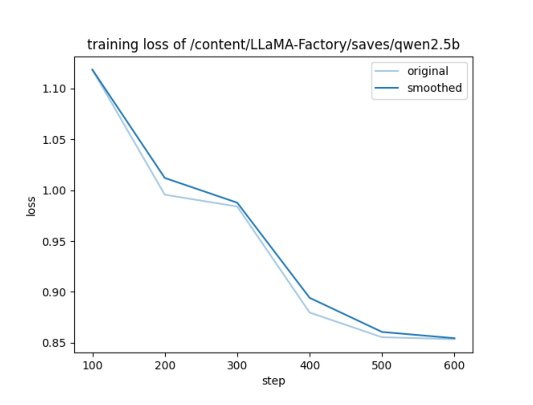

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread('/content/LLaMA-Factory/saves/qwen2.5b/training_loss.png')
plt.figure(figsize=(11, 5))
plt.imshow(img)
plt.axis('off')
plt.show()


## Inferences

In [ ]:
%cd /content/LLaMA-Factory/src

from llamafactory.chat import ChatModel
from llamafactory.extras.misc import torch_gc


%cd /content/LLaMA-Factory
args = dict(
  model_name_or_path="/content/Qwen2.5-1.5B-Instruct",
  adapter_name_or_path="/content/LLaMA-Factory/saves/qwen2.5b",
  template="qwen",
  finetuning_type="lora",
)
chat_model = ChatModel(args)

# show 5 test data
sampled_test = random.sample(test_data, 5)
test_output = []

for i in range(len(sampled_test)):
  messages = [] #no need for history context

  query = sampled_test[i]["instruction"]
  messages.append({"role": "user", "content": query})
  # print("Assistant: ", end="", flush=True)

  response = ""
  for new_text in chat_model.stream_chat(messages):
    # print(new_text, end="", flush=True)
    response += new_text
  # print()
  messages.append({"role": "assistant", "content": response})

  item = {"question: ": query,
          "generated_answer: ": response,
          "ground_truth: ": sampled_test[i]["output"]}
  # print(item)
  test_output.append(item)

torch_gc()

/content/LLaMA-Factory/src


[INFO|tokenization_utils_base.py:2058] 2025-04-19 14:09:02,799 >> loading file vocab.json
[INFO|tokenization_utils_base.py:2058] 2025-04-19 14:09:02,800 >> loading file merges.txt
[INFO|tokenization_utils_base.py:2058] 2025-04-19 14:09:02,802 >> loading file tokenizer.json
[INFO|tokenization_utils_base.py:2058] 2025-04-19 14:09:02,803 >> loading file added_tokens.json
[INFO|tokenization_utils_base.py:2058] 2025-04-19 14:09:02,804 >> loading file special_tokens_map.json
[INFO|tokenization_utils_base.py:2058] 2025-04-19 14:09:02,805 >> loading file tokenizer_config.json
[INFO|tokenization_utils_base.py:2058] 2025-04-19 14:09:02,805 >> loading file chat_template.jinja


/content/LLaMA-Factory


[INFO|tokenization_utils_base.py:2323] 2025-04-19 14:09:03,175 >> Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
[INFO|configuration_utils.py:691] 2025-04-19 14:09:03,176 >> loading configuration file /content/Qwen2.5-1.5B-Instruct/config.json
[INFO|configuration_utils.py:765] 2025-04-19 14:09:03,181 >> Model config Qwen2Config {
  "architectures": [
    "Qwen2ForCausalLM"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 151643,
  "eos_token_id": 151645,
  "hidden_act": "silu",
  "hidden_size": 1536,
  "initializer_range": 0.02,
  "intermediate_size": 8960,
  "max_position_embeddings": 32768,
  "max_window_layers": 21,
  "model_type": "qwen2",
  "num_attention_heads": 12,
  "num_hidden_layers": 28,
  "num_key_value_heads": 2,
  "rms_norm_eps": 1e-06,
  "rope_scaling": null,
  "rope_theta": 1000000.0,
  "sliding_window": 32768,
  "tie_word_embeddings": true,
  "torch_dtype": "bfloat16",
  "transformers_version": "4

[INFO|2025-04-19 14:09:03] llamafactory.data.template:143 >> Add <|im_end|> to stop words.


[INFO|configuration_utils.py:691] 2025-04-19 14:09:03,602 >> loading configuration file /content/Qwen2.5-1.5B-Instruct/config.json
[INFO|configuration_utils.py:765] 2025-04-19 14:09:03,604 >> Model config Qwen2Config {
  "architectures": [
    "Qwen2ForCausalLM"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 151643,
  "eos_token_id": 151645,
  "hidden_act": "silu",
  "hidden_size": 1536,
  "initializer_range": 0.02,
  "intermediate_size": 8960,
  "max_position_embeddings": 32768,
  "max_window_layers": 21,
  "model_type": "qwen2",
  "num_attention_heads": 12,
  "num_hidden_layers": 28,
  "num_key_value_heads": 2,
  "rms_norm_eps": 1e-06,
  "rope_scaling": null,
  "rope_theta": 1000000.0,
  "sliding_window": 32768,
  "tie_word_embeddings": true,
  "torch_dtype": "bfloat16",
  "transformers_version": "4.51.3",
  "use_cache": true,
  "use_sliding_window": false,
  "vocab_size": 151936
}



[INFO|2025-04-19 14:09:03] llamafactory.model.model_utils.kv_cache:143 >> KV cache is enabled for faster generation.


[INFO|modeling_utils.py:1121] 2025-04-19 14:09:03,669 >> loading weights file /content/Qwen2.5-1.5B-Instruct/model.safetensors
[INFO|modeling_utils.py:2167] 2025-04-19 14:09:03,671 >> Instantiating Qwen2ForCausalLM model under default dtype torch.bfloat16.
[INFO|configuration_utils.py:1142] 2025-04-19 14:09:03,675 >> Generate config GenerationConfig {
  "bos_token_id": 151643,
  "eos_token_id": 151645
}

[WARNING|logging.py:328] 2025-04-19 14:09:03,679 >> Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.
[INFO|modeling_utils.py:4930] 2025-04-19 14:09:17,332 >> All model checkpoint weights were used when initializing Qwen2ForCausalLM.

[INFO|modeling_utils.py:4938] 2025-04-19 14:09:17,333 >> All the weights of Qwen2ForCausalLM were initialized from the model checkpoint at /content/Qwen2.5-1.5B-Instruct.
If your task is similar to the task the model of the checkpoint was trained on, you can already use Qwen2ForCausalLM for predicti

[INFO|2025-04-19 14:09:17] llamafactory.model.model_utils.attention:143 >> Using torch SDPA for faster training and inference.
[INFO|2025-04-19 14:09:18] llamafactory.model.adapter:143 >> Merged 1 adapter(s).
[INFO|2025-04-19 14:09:18] llamafactory.model.adapter:143 >> Loaded adapter(s): /content/LLaMA-Factory/saves/qwen2.5b
[INFO|2025-04-19 14:09:18] llamafactory.model.loader:143 >> all params: 1,543,714,304


In [ ]:
for data in test_output:
  # data = {"1": "fgdsbk", "2": "skfb", "3": "rfhb"}
  print(tabulate([(k, v) for k, v in data.items()],
                tablefmt="grid"))
  print("\n\n")

+-------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
# !huggingface-cli login
# import json

# args = dict(
#   model_name_or_path="meta-llama/Meta-Llama-3-8B-Instruct", # 使用非量化的官方 Llama-3-8B-Instruct 模型
#   adapter_name_or_path="llama3_lora",                       # 加载之前保存的 LoRA 适配器
#   template="llama3",                                        # 和训练保持一致
#   finetuning_type="lora",                                   # 和训练保持一致
#   export_dir="llama3_lora_merged",                          # 合并后模型的保存目录
#   export_size=2,                                            # 合并后模型每个权重文件的大小（单位：GB）
#   export_device="cpu",                                      # 合并模型使用的设备：`cpu` 或 `auto`
#   # export_hub_model_id="your_id/your_model",               # 用于上传模型的 HuggingFace 模型 ID
# )

# json.dump(args, open("merge_llama3.json", "w", encoding="utf-8"), indent=2)

# %cd /content/LLaMA-Factory/

# !llamafactory-cli export merge_llama3.json